

Import common package

In [1]:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Import homemade code

In [2]:

from qcat.state_discrimination.discriminator import train_GMModel
from qcat.visualization.readout_fidelity import plot_readout_fidelity


File formate translate (QM)

In [3]:
dataset = xr.open_dataset(r"d:\Data\5Q4C0510_DR1_AS16\20240618_1903_ro_amp_q4_xy.nc")
print(dataset)
transposed_data = dataset.transpose( "frequency", "mixer", "prepare_state", "shot")

format_data = {}
for ro_name, data in transposed_data.data_vars.items(): 
    new_data = data.values*1000
    format_data[ro_name] = new_data
    print(ro_name)


<xarray.Dataset>
Dimensions:        (mixer: 2, shot: 1000, frequency: 100, prepare_state: 2)
Coordinates:
  * mixer          (mixer) <U1 'I' 'Q'
  * frequency      (frequency) float64 -5.0 -4.9 -4.8 -4.7 ... 4.6 4.7 4.8 4.9
  * prepare_state  (prepare_state) int32 0 1
  * shot           (shot) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    q3_ro          (mixer, shot, frequency, prepare_state) float64 ...
    q4_ro          (mixer, shot, frequency, prepare_state) float64 ...
Attributes:
    ro_LO:        [6130000000 6130000000]
    ro_IF:        [ -60000000 -178800000]
    xy_LO:        5100000000
    xy_IF:        -145180000
    xy_elements:  q4_xy
    start_time:   20240618_190213
    end_time:     20240618_190315
q3_ro
q4_ro


File formate translate (Qblox)

Create Discriminator object to analyze data

(100, 2, 2, 1000)


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\s

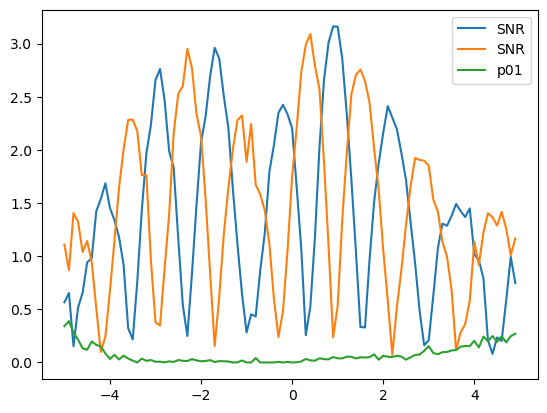

In [6]:

ro_name = "q4_ro"

freq = transposed_data.coords["frequency"]
training_data = format_data[ro_name] #your (2,2,N) data to train
print(training_data.shape)
snr = []
p01 = []
for i in range(training_data.shape[0]):
    trained_GMModel = train_GMModel(training_data[i])
    # For loop start here
    analysis_data = training_data[i] #your (2,2,N) data to analysis

    new_data = np.moveaxis( analysis_data ,1,0)

    p0_pop = trained_GMModel.get_state_population(new_data[0].transpose())
    p1_pop = trained_GMModel.get_state_population(new_data[1].transpose())
    # print(p0_pop, p1_pop)

    from qcat.state_discrimination.discriminator import train_1DGaussianModel, get_proj_distance, get_probability, p01_to_Teff

    centers, sigmas = trained_GMModel.output_1D_paras()


    # print(centers, centers.transpose(), analysis_data.shape)
    train_data_proj = get_proj_distance(centers.transpose(), analysis_data)
    pos = get_proj_distance(centers.transpose(),centers.transpose())
    trained_1DGModel = train_1DGaussianModel( train_data_proj.flatten(), (pos,sigmas) )
    # # Histogram plot
    bin_center, hist_0, p0_result = trained_1DGModel.fit_distribution(train_data_proj[0])
    # print(p0_result.fit_report())
    dis = np.abs(pos[1]-pos[0])
    sigma = np.max( sigmas )
    snr.append(dis/sigma)
    p0 = get_probability(p0_result)
    p01.append(p0[1])
    
plt.plot(freq, np.array(snr),label="SNR")
plt.plot(freq, np.array(p01),label="p01")
plt.legend()